# Transformer-Based Recommendation System
- **Dataset**: MovieLens 1M (1M ratings, 6,040 users, 3,952 movies) with `ratings.dat` (user ratings) and `movies.dat` (movie metadata).
- **Goal**: Predict movie ratings based on user rating sequences using BERT/Transformer.
- **My Focus**: Explore how pre-trained sentence embeddings enhance prediction accuracy.

### Data Preparation
This part focuses on the prapation of the data, including

1. **Loading**: Imported `ratings.dat` and `movies.dat` with pandas, sorted ratings by user and timestamp.
2. **Sequences**: Built user sequences of movie ratings, capped at a fixed length (e.g., 50), padded shorter sequences.
3. **Embeddings**: Generated 384-dimensional embeddings for each movie using `SentenceTransformer("all-MiniLM-L6-v2")` on concatenated `Title` and `Genres`.
4. **Input Format**: Created tensors of embeddings and ratings, with attention masks for padding.
5. **Loaders**: Split data into 80% train/20% test, used PyTorch `DataLoader` for batching (shuffled for train, unshuffled for test).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Course/CS247 - Advanced Data Mining/Final Project/CS247-Project/

/content/drive/MyDrive/Course/CS247 - Advanced Data Mining/Final Project/CS247-Project


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertConfig
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Function to load the MovieLens dataset
def load_data(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId", "movieId", "rating", "timestamp"])
    df = df.sort_values(by=["userId", "timestamp"])  # Sort by user and timestamp
    user_movie_dict = df.groupby("userId")["movieId"].apply(list).to_dict()
    return user_movie_dict

# Load dataset
user_movie_dict = load_data()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences")

# Print a sample of user-movie interactions for debugging
for user, movies in list(user_movie_dict.items())[:3]:
    print(f"User {user}: {movies}")

Loaded 6040 users' movie interaction sequences
User 1: [3186, 1270, 1721, 1022, 2340, 1836, 3408, 2804, 1207, 1193, 720, 260, 919, 608, 2692, 1961, 2028, 3105, 938, 1035, 1962, 2018, 150, 1028, 1097, 914, 1287, 2797, 2762, 1246, 661, 2918, 531, 3114, 2791, 2321, 1029, 1197, 594, 2398, 1545, 527, 595, 2687, 745, 588, 1, 2355, 2294, 783, 1566, 1907, 48]
User 2: [1198, 1210, 1217, 2717, 1293, 2943, 1225, 1193, 318, 3030, 2858, 1213, 1945, 1207, 593, 3095, 3468, 1873, 515, 1090, 2501, 3035, 110, 2067, 3147, 1247, 3105, 1357, 1196, 1957, 1953, 920, 1834, 1084, 1962, 3471, 3654, 3735, 1259, 1954, 1784, 2728, 1968, 1103, 902, 3451, 3578, 2852, 3334, 3068, 265, 2312, 590, 1253, 3071, 1244, 3699, 1955, 1245, 2236, 3678, 982, 2194, 2268, 1442, 3255, 647, 235, 1096, 1124, 498, 1246, 3893, 1537, 1188, 2396, 2359, 2321, 356, 3108, 1265, 3809, 589, 2028, 2571, 457, 2916, 1610, 480, 163, 380, 3418, 3256, 1408, 21, 349, 1527, 2353, 2006, 2278, 1370, 648, 2427, 1792, 1372, 1552, 2490, 1385, 780, 2881, 

In [ ]:
# Function to load the movie lens dataset and check the data as pandas dataframe
def load_data(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId", "movieId", "rating", "timestamp"])
    df = df.sort_values(by=["userId", "timestamp"])  # Sort by user and timestamp
    return df

# Load dataset
ratings = load_data()
ratings.head()


,userId,movieId,rating,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [ ]:
# Check null
ratings.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 38.2 MB


In [ ]:
# Function to load the movie lens dataset and check the data as pandas dataframe
def load_data(filepath="ml-1m/users.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId","gender","age","occupation","zipCode"])
    df = df.sort_values(by=["userId"])  # Sort by user
    return df

# Load dataset
users = load_data()
users.head()

,userId,gender,age,occupation,zipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
# Replace gender with 0 and 1 for Female and Male
users.gender = users.gender.astype("category").cat.codes

users.head()

,userId,gender,age,occupation,zipCode
0,1,0,1,10,48067
1,2,1,56,16,70072
2,3,1,25,15,55117
3,4,1,45,7,02460
4,5,1,25,20,55455


In [ ]:
# Check the columns
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   int8  
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipCode     6040 non-null   object
dtypes: int64(3), int8(1), object(1)
memory usage: 194.8+ KB


In [ ]:
def load_data(filepath="ml-1m/movies.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["movieId","title","genres"], encoding="ISO-8859-1")
    df = df.sort_values(by=["movieId"])  # Sort by movieId
    return df

# Load dataset
movies = load_data()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Seperate the title column into title and year
def separate_title_year(title):
    # Extract the year from the title
    year = title[-5:-1]
    # Remove the year from the title
    title = title[:-7]
    return title, year


# Apply the function to the title column
movies["title"], movies["year"] = zip(*movies["title"].apply(separate_title_year))
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
# Check the columns
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
 3   year     3883 non-null   object
dtypes: int64(1), object(3)
memory usage: 121.5+ KB


In [ ]:
# Replace | with a space
movies["genres"] = movies["genres"].str.replace("|", ", ")
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"Animation, Children's, Comedy",1995
1,2,Jumanji,"Adventure, Children's, Fantasy",1995
2,3,Grumpier Old Men,"Comedy, Romance",1995
3,4,Waiting to Exhale,"Comedy, Drama",1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
# Comcat title and genres
movies["title_genres"] = movies["title"] + ", " + movies["genres"]
movies.head()


,movieId,title,genres,year,title_genres
0,1,Toy Story,"Animation, Children's, Comedy",1995,"Toy Story, Animation, Children's, Comedy"
1,2,Jumanji,"Adventure, Children's, Fantasy",1995,"Jumanji, Adventure, Children's, Fantasy"
2,3,Grumpier Old Men,"Comedy, Romance",1995,"Grumpier Old Men, Comedy, Romance"
3,4,Waiting to Exhale,"Comedy, Drama",1995,"Waiting to Exhale, Comedy, Drama"
4,5,Father of the Bride Part II,Comedy,1995,"Father of the Bride Part II, Comedy"


In [ ]:
# Merge the three dataframes
data = ratings.merge(users, on="userId").merge(movies, on="movieId")
data.head()

,userId,movieId,rating,timestamp,gender,age,occupation,zipCode,title,genres,year,title_genres
0,1,3186,4,978300019,0,1,10,48067,"Girl, Interrupted",Drama,1999,"Girl, Interrupted, Drama"
1,1,1270,5,978300055,0,1,10,48067,Back to the Future,"Comedy, Sci-Fi",1985,"Back to the Future, Comedy, Sci-Fi"
2,1,1721,4,978300055,0,1,10,48067,Titanic,"Drama, Romance",1997,"Titanic, Drama, Romance"
3,1,1022,5,978300055,0,1,10,48067,Cinderella,"Animation, Children's, Musical",1950,"Cinderella, Animation, Children's, Musical"
4,1,2340,3,978300103,0,1,10,48067,Meet Joe Black,Romance,1998,"Meet Joe Black, Romance"


In [ ]:

def load_data(filepath="ml-1m"):
    '''
    This function loads the MovieLens 1M dataset and returns a pandas dataframe
    including the ratings, users, movies etc.
    '''


    # Load the data
    ratings = pd.read_csv(f"{filepath}/ratings.dat", sep="::", engine="python",
                          names=["userId", "movieId", "rating", "timestamp"])
    users = pd.read_csv(f"{filepath}/users.dat", sep="::", engine="python",
                        names=["userId","gender","age","occupation","zipCode"])
    movies = pd.read_csv(f"{filepath}/movies.dat", sep="::", engine="python",
                         names=["movieId","title","genres"], encoding="ISO-8859-1")

    # Sort ratings by user and timestamp
    ratings = ratings.sort_values(by=["userId", "timestamp"])

    # Replace gender with 0 and 1 for Female and Male
    users.gender = users.gender.astype("category").cat.codes

    # Clean the genres column, it separates the genres by "|"
    def clean_genres(genres):
        return genres.split("|")

    # Apply the function to the genres column
    movies["genres"] = movies["genres"].apply(clean_genres)

    # Seperate the title column into title and year
    def separate_title_year(title):
        # Extract the year from the title
        year = title[-5:-1]
        # Remove the year from the title
        title = title[:-7]
        return title, year


    # Apply the function to the title column
    movies["title"], movies["year"] = zip(*movies["title"].apply(separate_title_year))

    # Get all the unique genres
    unique_genres = set()

    for genres in movies["genres"]:
        unique_genres.update(genres)

    # Create a code for each genre and store it in a dictionary
    genre_to_code = {genre: code for code, genre in enumerate(unique_genres)}
    code_to_genre = {code: genre for genre, code in genre_to_code.items()}

    # Add a column for the genre codes
    movies["genre_codes"] = movies["genres"].apply(lambda x: [genre_to_code[genre] for genre in x])

    # Merge the three dataframes
    data = ratings.merge(users, on="userId").merge(movies, on="movieId")

    return data, genre_to_code, code_to_genre

In [ ]:
# Load the data
data, genre_to_code, code_to_genre = load_data()
data.head()

,userId,movieId,rating,timestamp,gender,age,occupation,zipCode,title,genres,year,genre_codes
0,1,3186,4,978300019,0,1,10,48067,"Girl, Interrupted",[Drama],1999,[6]
1,1,1270,5,978300055,0,1,10,48067,Back to the Future,"[Comedy, Sci-Fi]",1985,"[9, 2]"
2,1,1721,4,978300055,0,1,10,48067,Titanic,"[Drama, Romance]",1997,"[6, 12]"
3,1,1022,5,978300055,0,1,10,48067,Cinderella,"[Animation, Children's, Musical]",1950,"[10, 13, 17]"
4,1,2340,3,978300103,0,1,10,48067,Meet Joe Black,[Romance],1998,[12]


In [ ]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)

embeddings.shape


(3, 384)

In [ ]:
# Extract only userid, movieid, and title_genre column from data
data_prep = data[['userId', 'movieId', 'timestamp']]

data_prep.head()

,userId,movieId,timestamp
0,1,3186,978300019
1,1,1270,978300055
2,1,1721,978300055
3,1,1022,978300055
4,1,2340,978300103


In [ ]:
# Use the title_genres column in the movies dataframe to embed the title_genres column in the data dataframe
movies["title_genres_embedding"] = movies["title_genres"].apply(lambda x: model.encode(x))

movies.head()

,movieId,title,genres,year,title_genres,title_genres_embedding
0,1,Toy Story,"Animation, Children's, Comedy",1995,"Toy Story, Animation, Children's, Comedy","[-0.042061217, -0.05036443, 0.05309302, 0.0070..."
1,2,Jumanji,"Adventure, Children's, Fantasy",1995,"Jumanji, Adventure, Children's, Fantasy","[0.0032210886, 0.0763571, 0.037274607, -0.0126..."
2,3,Grumpier Old Men,"Comedy, Romance",1995,"Grumpier Old Men, Comedy, Romance","[-0.021038508, -0.07637456, 0.0022655223, -0.0..."
3,4,Waiting to Exhale,"Comedy, Drama",1995,"Waiting to Exhale, Comedy, Drama","[-0.012850011, -0.11153921, -0.011487491, 0.02..."
4,5,Father of the Bride Part II,Comedy,1995,"Father of the Bride Part II, Comedy","[-0.055391755, -0.006884502, -0.029818444, 0.0..."


In [ ]:
# Take movieId and title_genres_embedding
movies_prep = movies[['movieId','title_genres_embedding']]

# Merge data_prep and movie_prep using movieId
data_merged = data_prep.merge(movies_prep, on='movieId')


data_merged.head()

,userId,movieId,timestamp,title_genres_embedding
0,1,3186,978300019,"[-0.0016497438, -0.048914276, 0.022234796, -0...."
1,1,1270,978300055,"[-0.06946387, -0.091070846, -0.031258695, 0.00..."
2,1,1721,978300055,"[-0.0145651875, -0.10387791, 0.04753983, 0.082..."
3,1,1022,978300055,"[0.016511321, -0.018827125, 0.049624685, 0.022..."
4,1,2340,978300103,"[-0.052338403, -0.031927496, -0.03963431, 0.09..."


In [ ]:
# Sort data_merged by userId and timestamp
data_merged = data_merged.sort_values(['userId', 'timestamp'])

data_merged.head()


,userId,movieId,timestamp,title_genres_embedding
0,1,3186,978300019,"[-0.0016497438, -0.048914276, 0.022234796, -0...."
1,1,1270,978300055,"[-0.06946387, -0.091070846, -0.031258695, 0.00..."
2,1,1721,978300055,"[-0.0145651875, -0.10387791, 0.04753983, 0.082..."
3,1,1022,978300055,"[0.016511321, -0.018827125, 0.049624685, 0.022..."
4,1,2340,978300103,"[-0.052338403, -0.031927496, -0.03963431, 0.09..."


In [ ]:
# Create a dictionary to store the user-movie interaction sequences
user_movie_embedding_dict = data_merged.groupby('userId')['title_genres_embedding'].apply(list).to_dict()

In [ ]:
user_movie_dict = data_merged.groupby('userId')['movieId'].apply(list).to_dict()


In [ ]:
# Function to split user interactions into train and test sets
def split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5):
    train_dict, test_dict = {}, {}

    for user, movies in user_movie_dict.items():
        if len(movies) >= min_interactions:  # Only split users with enough data
            split_idx = int(len(movies) * (1 - test_ratio))
            train_dict[user] = movies[:split_idx]
            test_dict[user] = movies[split_idx:]
        else:
            train_dict[user] = movies  # Assign all to train if only a few interactions

    return train_dict, test_dict

# Apply train-test split with filtering
train_movie_dict, test_movie_dict = split_train_test(user_movie_dict, test_ratio=0.2, min_interactions=5)

train_embedding_dict, test_embedding_dict = split_train_test(user_movie_embedding_dict, test_ratio=0.2, min_interactions=5)

# Print updated user counts
print(f"Train users: {len(train_movie_dict)}, Test users: {len(test_movie_dict)}")
print(f"Train users: {len(train_embedding_dict)}, Test users: {len(test_embedding_dict)}")


Train users: 6040, Test users: 6040
Train users: 6040, Test users: 6040


In [ ]:
# Make sure lengths match
train_data = {}
for user in train_movie_dict:
    movie_seq = train_movie_dict[user]
    emb_seq = train_embedding_dict[user]
    assert len(movie_seq) == len(emb_seq)
    train_data[user] = (movie_seq, emb_seq)

In [ ]:
test_data = {}
for user in test_movie_dict:
    movie_seq = test_movie_dict[user]
    emb_seq = test_embedding_dict[user]
    assert len(movie_seq) == len(emb_seq)
    test_data[user] = (movie_seq, emb_seq)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class BERT4RecDataset(Dataset):
    def __init__(self, user_data, max_seq_len=50):
        """
        user_data is a dict: { user_id: (movie_seq, emb_seq) }
            movie_seq: list of item IDs
            emb_seq: list of 384-dim embeddings
        max_seq_len: maximum sequence length
        """
        self.samples = []

        # Store the user_data as a list of tuples (movie_seq, emb_seq)
        for user, (movie_seq, emb_seq) in user_data.items():
            self.samples.append((movie_seq, emb_seq))


        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.samples) # This line is to return the length of the dataset


    def __getitem__(self, idx): # This function is to get the item at a particular index
        movie_seq, emb_seq = self.samples[idx]

        # 1) Truncate or pad the movie sequence to the max_seq_len
        if len(movie_seq) > self.max_seq_len:
            movie_seq = movie_seq[-self.max_seq_len:] # to keep the last max_seq_len items
            emb_seq = emb_seq[-self.max_seq_len:]

        else:
            # pad the sequence
            pad_len = self.max_seq_len - len(movie_seq)
            movie_seq = list(movie_seq)
            movie_seq += [0]*pad_len

            # Embedding squence to be padded with zeros of shape (384,)
            emb_seq = emb_seq + [np.zeros(384)] * pad_len

        target_ids = movie_seq[1:] + [0]  # Next-movie prediction

        # attention_mask is 1 for real tokens and 0 for padding tokens
        attention_mask = [1 if m != 0 else 0 for m in movie_seq]

        # Convert all of the sequences to PyTorch tensors
        movie_seq = torch.LongTensor(movie_seq) #(max_seq_len,)
        emb_seq = [torch.tensor(emb, dtype=torch.float) for emb in emb_seq]
        emb_seq = torch.stack(emb_seq, dim=0) #(max_seq_len, 384)
        attention_mask = torch.tensor(attention_mask) #(max_seq_len,)


        return movie_seq, emb_seq, attention_mask

In [ ]:
from torch.utils.data import DataLoader

train_dataset = BERT4RecDataset(train_data, max_seq_len=50)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
test_dataset = BERT4RecDataset(test_data, max_seq_len=50)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
len(test_data)

6040

# BERT Modeling


### Overview
This project implements a BERT-based recommendation model enhanced with a causal mask. It leverages HuggingFace's pre-trained BERT model and the original MovieLens 1M dataset, focusing exclusively on sequential data to capture user interaction patterns.

### Key Features
- **Transformer Encoder:** Utilizes a pre-trained BERT model to leverage deep contextual representations.
- **Sequential Data Focus:** Processes user-item interaction sequences from the MovieLens 1M dataset.
- **Causal Masking:** Applies a causal mask to ensure the model only attends to past interactions.

### Causal Masking Details
The causal mask is a critical component that prevents the model from accessing future items in a user's sequence. Traditional Transformer encoders use bidirectional self-attention, considering both past and future contexts. In this implementation, the causal mask restricts attention to historical data only, simulating real-world scenarios where future user interactions are unknown.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class BERT4RecDataset_BERT(Dataset):
    def __init__(self, user_data, max_seq_len=50):
        """
        user_data is a dict: { user_id: (movie_seq, emb_seq) }
            movie_seq: list of item IDs
            emb_seq: list of 384-dim embeddings
        max_seq_len: maximum sequence length
        """
        self.samples = []

        # Store the user_data as a list of tuples (movie_seq, emb_seq)
        for user, (movie_seq, emb_seq) in user_data.items():
            self.samples.append((movie_seq, emb_seq))


        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.samples) # This line is to return the length of the dataset


    def __getitem__(self, idx): # This function is to get the item at a particular index
        movie_seq, emb_seq = self.samples[idx]

        # 1) Truncate or pad the movie sequence to the max_seq_len
        if len(movie_seq) > self.max_seq_len:
            movie_seq = movie_seq[-self.max_seq_len:] # to keep the last max_seq_len items
            emb_seq = emb_seq[-self.max_seq_len:]

        else:
            # pad the sequence
            pad_len = self.max_seq_len - len(movie_seq)
            movie_seq = list(movie_seq)
            movie_seq += [0]*pad_len

            # Embedding squence to be padded with zeros of shape (384,)
            emb_seq = emb_seq + [np.zeros(384)] * pad_len

        target_seq = movie_seq[1:] + [0]  # Next-movie prediction

        # attention_mask is 1 for real tokens and 0 for padding tokens
        attention_mask = [1 if m != 0 else 0 for m in movie_seq]

        # Convert all of the sequences to PyTorch tensors
        movie_seq = torch.LongTensor(movie_seq) #(max_seq_len,)
        target_seq = torch.LongTensor(target_seq) #(max_seq_len,)
        emb_seq = [torch.tensor(emb, dtype=torch.float) for emb in emb_seq]
        emb_seq = torch.stack(emb_seq, dim=0) #(max_seq_len, 384)
        attention_mask = torch.tensor(attention_mask) #(max_seq_len,)



        return movie_seq, emb_seq, target_seq, attention_mask

train_BERT_dataset = BERT4RecDataset_BERT(train_data, max_seq_len=50)
train_BERT_loader = DataLoader(train_BERT_dataset, batch_size=64, shuffle=True)

test_BERT_dataset = BERT4RecDataset_BERT(test_data, max_seq_len=50)
test_BERT_loader = DataLoader(test_BERT_dataset, batch_size=64, shuffle=False)

In [ ]:
# Check the test_loader data
for i, (movie_seq, _, target_seq, attention_mask) in enumerate(train_BERT_loader):
    print(f"Movie sequence shape: {movie_seq.shape}")
    print(f"Target sequence shape: {target_seq.shape}")
    print(f"Attention mask shape: {attention_mask.shape}")
    break

# Check the embedding sequence for the  sample
print(attention_mask[10])
print(target_seq[10])


Movie sequence shape: torch.Size([64, 50])
Target sequence shape: torch.Size([64, 50])
Attention mask shape: torch.Size([64, 50])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])
tensor([1020, 3712, 2003, 3398,  410, 1405, 2060, 2683, 1760,  587, 2011, 3254,
        3033, 2141,  413,  435, 1391, 2012, 2792, 2413,  520,  344, 3247, 1713,
         355,  231, 2375, 2953, 3248, 3392,   19,   65, 1707, 2382,  296, 1645,
         367,  137,   32, 1097, 1914, 3386,  150,  508, 1673, 1302, 1682, 3668,
        1059,    0])


In [ ]:
class BERT4Rec_BERT(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=4, num_heads=8, max_len=50):
      '''
      vocab_size: total vocabulary size
      hidden_size: hidden size of the model
      num_layers: number of layers
      num_heads: number of attention heads
      max_len: maximum sequence length of movie ids
      '''
        super(BERT4Rec_BERT, self).__init__()

        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            num_hidden_layers=num_layers,
            max_position_embeddings=max_len,
        )

        self.bert = BertModel(config)

        self.output_layer = nn.Linear(hidden_size, vocab_size)
    def get_causal_mask(self, seq_len, device):
       return torch.tril(torch.ones((seq_len, seq_len), device=device))


    def forward(self, input_ids, attention_mask):

            batch_size, seq_len = input_ids.shape

            # Create causal mask for preventing the model to see future data
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=input_ids.device), diagonal=1)

            # BERT modeling
            output = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_attention_mask=~causal_mask
            ).last_hidden_state
            return self.output_layer(output)

# Check vocab size
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1

# Model initiation
model = BERT4Rec_BERT(vocab_size).to(device)

print(f"Initialized BERT4Rec model with vocab size {vocab_size}")

Initialized BERT4Rec model with vocab size 3953


In [ ]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Define Training Function
def train_model(model, dataloader, epochs=3, lr=0.001, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Added scheduler for preventing gradient on plateau
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    # Early stopping variables
    best_train_loss = float('inf')  # Track the best training loss
    patience_counter = 0  # Count epochs without improvement
    best_model_state = None  # Store the best model weights

    model.train()

    BERT_Base = [] # Store loss for final plot

    for epoch in range(epochs):
        total_loss = 0
        for inputs, embeddings, targets, attention_mask in dataloader:
            inputs, embeddings, targets, attention_mask = inputs.to(device), embeddings.to(), targets.to(device), attention_mask.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        avg_train_loss = total_loss / len(dataloader)

        scheduler.step(avg_train_loss)


        BERT_Base.append(avg_train_loss)


        print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(dataloader)}")

        # Early stopping logic based on training loss
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.", f"LR: {scheduler.get_last_lr()[0]:.6f}")
                break

    return BERT_Base


# Train on Train DataLoader
BERT_Base = train_model(model, train_BERT_loader, epochs=100, lr= 0.0005)

Epoch 1, Train Loss: 7.503783030258981
Epoch 2, Train Loss: 7.327825571361341
Epoch 3, Train Loss: 6.394309345044587
Epoch 4, Train Loss: 3.8828642656928616
Epoch 5, Train Loss: 0.909586312896327
Epoch 6, Train Loss: 0.2553670091064353
Epoch 7, Train Loss: 0.11552145273277634
Epoch 8, Train Loss: 0.06245236663441909
Epoch 9, Train Loss: 0.03914778079641493
Epoch 10, Train Loss: 0.026397148068798216
Epoch 11, Train Loss: 0.020663012064209108
Epoch 12, Train Loss: 0.01603623111977389
Epoch 13, Train Loss: 0.011616592481732368
Epoch 14, Train Loss: 0.011368729958408758
Epoch 15, Train Loss: 0.009185446700767467
Epoch 16, Train Loss: 0.007219841507704635
Epoch 17, Train Loss: 0.006180010824219177
Epoch 18, Train Loss: 0.005962323485628555
Epoch 19, Train Loss: 0.005832369179513894
Epoch 20, Train Loss: 0.004677341996054901
Epoch 21, Train Loss: 0.00350841348990798
Epoch 22, Train Loss: 0.003427619619393035
Epoch 23, Train Loss: 0.003558258851990104
Epoch 24, Train Loss: 0.00288854820016575

In [ ]:
# Define Evaluation Function
def evaluate_model_BERT(model, dataloader, k=10):
    model.eval()
    total_loss = 0
    total_recall = 0
    total_ndcg = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    with torch.no_grad():
        for inputs, embedding, targets, attention_mask in dataloader:
            inputs, targets, attention_mask = inputs.to(device), targets.to(device), attention_mask.to(device)

            outputs = model(inputs, attention_mask)  # (batch_size, seq_len, vocab_size)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            # Compute Recall@K & NDCG@K
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)  # Get top K movie predictions
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return avg_loss, avg_recall, avg_ndcg

# Compute Recall@K
def recall_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # Check if target is in top K
    recall = hits.sum(dim=-1).mean().item()  # Compute recall
    return recall

# Compute ndcg@K
def ndcg_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()
    discount = 1 / torch.log2(torch.arange(2, k + 2, device=targets.device).float())
    dcg = (hits * discount).sum(dim=-1)
    idcg = discount[0]

    # Avoid division by zero if idcg is zero
    ndcg = (dcg / idcg).mean().item() if idcg > 0 else 0.0
    return ndcg

# Evaluate on Test DataLoader
test_loss, recall_k, ndcg_k = evaluate_model_BERT(model, test_BERT_loader, k=10)

Test Loss: 0.0162, Recall@10: 0.4691, NDCG@10: 0.4690


In [ ]:
def inspect_predictions(model, dataloader, k=10, num_samples=5, device='cuda'):
    """Inspect individual predictions and metrics"""
    model.eval()


    with torch.no_grad():
        for item_ids, text_emb, target_ids, attn_mask in dataloader:
            item_ids, target_ids, attn_mask = item_ids.to(device), target_ids.to(device), attn_mask.to(device)

            outputs = model(item_ids, target_ids)  # (batch_size, seq_len, vocab_size)



            # Get top-K predictions
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)

            # Print details for the first few samples
            for i in range(min(num_samples, item_ids.size(0))):
                seq_len = attn_mask[i].sum().item()
                print(f"\nSample {i+1}, Sequence length: {seq_len}")

                for pos in range(seq_len):
                    true_item = target_ids[i, pos].item()
                    pred_items = top_k_predictions[i, pos].tolist()
                    hit = true_item in pred_items
                    rank = pred_items.index(true_item) + 1 if hit else "N/A"

                    print(f"  Pos {pos}: True={true_item}, Top-{k}={pred_items}, Hit={hit}, Rank={rank}")

            break  # Just process one batch

inspect_predictions(model, test_BERT_loader, k=10, num_samples=1, device=device)


Sample 1, Sequence length: 11
  Pos 0: True=2687, Top-10=[588, 539, 1777, 1033, 2384, 586, 13, 514, 1405, 39], Hit=False, Rank=N/A
  Pos 1: True=745, Top-10=[588, 539, 1777, 1033, 586, 13, 1032, 2384, 514, 357], Hit=False, Rank=N/A
  Pos 2: True=588, Top-10=[588, 539, 1033, 1777, 586, 13, 2384, 2700, 39, 2424], Hit=True, Rank=1
  Pos 3: True=1, Top-10=[588, 539, 1033, 2384, 586, 1032, 13, 1777, 357, 39], Hit=False, Rank=N/A
  Pos 4: True=2355, Top-10=[588, 539, 1777, 2384, 1033, 586, 13, 3052, 39, 1032], Hit=False, Rank=N/A
  Pos 5: True=2294, Top-10=[588, 539, 1777, 1033, 2384, 13, 2700, 3052, 1032, 586], Hit=False, Rank=N/A
  Pos 6: True=783, Top-10=[588, 539, 1033, 1777, 13, 1032, 2384, 586, 551, 2700], Hit=False, Rank=N/A
  Pos 7: True=1566, Top-10=[588, 539, 1033, 586, 13, 2700, 3052, 1777, 2384, 551], Hit=False, Rank=N/A
  Pos 8: True=1907, Top-10=[588, 539, 1033, 1777, 586, 13, 514, 1032, 2384, 837], Hit=False, Rank=N/A
  Pos 9: True=48, Top-10=[588, 539, 1033, 1777, 514, 1032,

# BERT Modeling with Word Embeddings

### Overview
This part extends the BERT-based recommendation model by incorporating word embeddings to encode additional movie metadata. It still leverages HuggingFace's pre-trained BERT model and the original MovieLens 1M dataset, focusing on sequential data, but now also utilizes HuggingFace's pre-trained Sentence Transformer model to embed movie genres and titles for improved sequence prediction.

### Key Features
- **Transformer Encoder:** Utilizes a pre-trained BERT model to capture deep contextual representations.
- **Sequential Data Focus:** Processes user-item interaction sequences from the MovieLens 1M dataset.
- **Causal Masking:** Applies a causal mask to restrict attention to past interactions only.
- **Integrated Word Embeddings:** Leverages a pre-trained Sentence Transformer model to embed movie genres and titles, providing enriched semantic information for predicting future user interactions.

### Word Embeddings Integration Details
This version integrates word embeddings to encode movie genre and title data. By using HuggingFace's pre-trained Sentence Transformer model, the approach enhances the model's understanding of movie attributes, which may lead to better predictions of the next item in a user's sequence.

In [ ]:
# Initiate BERT4Rec_BERT model for the integration of word embeddings
class BERT4Rec_BERT(nn.Module):
    def __init__(self, vocab_size, emb_size=384, hidden_size=256, num_layers=4, num_heads=4, max_len=50):
        super(BERT4Rec_BERT, self).__init__()

        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            num_hidden_layers=num_layers,
            max_position_embeddings=max_len,
        )

        self.bert = BertModel(config)

        self.word_embedding = nn.Linear(emb_size, hidden_size)

        # Apply a fuse_linear to concatenate the embeddings
        self.fuse_linear = nn.Linear(hidden_size * 2, hidden_size)

        self.layer_norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(0.1)

        self.output_layer = nn.Linear(hidden_size, vocab_size)
    def get_causal_mask(self, seq_len, device):
       return torch.tril(torch.ones((seq_len, seq_len), device=device))


    def forward(self, input_ids, emb_seq, attention_mask):
            batch_size, seq_len = input_ids.shape

            # Create Causal Mask**
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=input_ids.device), diagonal=1)

            movie_emb = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_attention_mask=~causal_mask  # PyTorch requires masked positions to be False
            ).last_hidden_state

            word_emb = self.word_embedding(emb_seq) # (batch, hidden_dim)
            word_emb = self.layer_norm(word_emb)
            word_emb = self.dropout(word_emb)


            #(batch, hidden_dim*2) --> #(batch, hidden_dim)
            output = self.fuse_linear(torch.cat([movie_emb, word_emb], dim=-1))

            return self.output_layer(output)


vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1
model = BERT4Rec_BERT(vocab_size, emb_size=384).to(device)

print(f"Initialized BERT4Rec model with vocab size {vocab_size} and word embedding")


# Define Training Function
def train_model(model, dataloader, epochs=3, lr=0.001, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    # Early stopping variables
    best_train_loss = float('inf')  # Track the best training loss
    patience_counter = 0  # Count epochs without improvement
    best_model_state = None  # Store the best model weights
    BERT_with_Embeddings = []

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, embeddings, targets, attention_mask in dataloader:
            inputs, embeddings, targets, attention_mask = inputs.to(device), embeddings.to(device), targets.to(device), attention_mask.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=inputs, emb_seq=embeddings, attention_mask=attention_mask)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)

        scheduler.step(avg_train_loss)


        BERT_with_Embeddings.append(avg_train_loss)


        print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(dataloader)}")

        # Early stopping logic based on training loss
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.", f"LR: {scheduler.get_last_lr()[0]:.6f}")
                break


    return BERT_with_Embeddings

# Train on Train DataLoader
BERT_with_Embeddings = train_model(model, train_BERT_loader, epochs=50, lr= 0.0005)


# Define Evaluation Function
def evaluate_model_BERT(model, dataloader, k=10):
    model.eval()
    total_loss = 0
    total_recall = 0
    total_ndcg = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    with torch.no_grad():
        for inputs, embedding, targets, attention_mask in dataloader:
            inputs, embedding, targets, attention_mask = inputs.to(device), embedding.to(device), targets.to(device), attention_mask.to(device)

            outputs = model(inputs, embedding, attention_mask)  # (batch_size, seq_len, vocab_size)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            # Compute Recall@K & NDCG@K
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)  # Get top K movie predictions
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return avg_loss, avg_recall, avg_ndcg

# Compute Recall@K
def recall_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # Check if target is in top K
    recall = hits.sum(dim=-1).mean().item()  # Compute recall
    return recall

# Compute NDCG@K
def ndcg_at_k(top_k_predictions, targets, k):
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()
    log_positions = 1 / torch.log2(torch.arange(2, k + 2, device=targets.device).float())  # Discount factor
    dcg = (hits * log_positions).sum(dim=-1).mean().item()
    return dcg

# Evaluate on Test DataLoader
test_loss, recall_k, ndcg_k = evaluate_model_BERT(model, test_BERT_loader, k=10)

Initialized BERT4Rec model with vocab size 3953 and word embedding
Epoch 1, Train Loss: 7.369282998536763
Epoch 2, Train Loss: 6.453021185021651
Epoch 3, Train Loss: 2.3306545270116708
Epoch 4, Train Loss: 0.3123929120992359
Epoch 5, Train Loss: 0.11162625570830546
Epoch 6, Train Loss: 0.05866586909090218
Epoch 7, Train Loss: 0.034159394647730025
Epoch 8, Train Loss: 0.023334552524121185
Epoch 9, Train Loss: 0.016397895330661223
Epoch 10, Train Loss: 0.011655433735761203
Epoch 11, Train Loss: 0.009749443608483201
Epoch 12, Train Loss: 0.010031904721338499
Epoch 13, Train Loss: 0.007994866974063609
Epoch 14, Train Loss: 0.005460567735625725
Epoch 15, Train Loss: 0.004530545971111247
Epoch 16, Train Loss: 0.004786842728131696
Epoch 17, Train Loss: 0.003971902349669682
Epoch 18, Train Loss: 0.003213820937334707
Epoch 19, Train Loss: 0.0028918073880241104
Epoch 20, Train Loss: 0.003149143564759901
Epoch 21, Train Loss: 0.002764151843362733
Epoch 22, Train Loss: 0.003815727150312772
Epoch 2

In [ ]:
BERT_with_Embeddings

[7.369282998536763,
 6.453021185021651,
 2.3306545270116708,
 0.3123929120992359,
 0.11162625570830546,
 0.05866586909090218,
 0.034159394647730025,
 0.023334552524121185,
 0.016397895330661223,
 0.011655433735761203,
 0.009749443608483201,
 0.010031904721338499,
 0.007994866974063609,
 0.005460567735625725,
 0.004530545971111247,
 0.004786842728131696,
 0.003971902349669682,
 0.003213820937334707,
 0.0028918073880241104,
 0.003149143564759901,
 0.002764151843362733,
 0.003815727150312772,
 0.004593786863168995,
 0.009150429922891291,
 0.014583376706822922,
 0.02066670223874481]

In [ ]:
def inspect_predictions(model, dataloader, k=10, num_samples=5, device='cuda'):
    '''Inspect individual predictions and metrics'''
    model.eval()


    with torch.no_grad():
        for item_ids, text_emb, target_ids, attn_mask in dataloader:
            item_ids, text_emb, target_ids, attn_mask = item_ids.to(device), text_emb.to(device), target_ids.to(device), attn_mask.to(device)

            outputs = model(item_ids, text_emb, target_ids)  # (batch_size, seq_len, vocab_size)



            # Get top-K predictions
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)

            # Print details for the first few samples
            for i in range(min(num_samples, item_ids.size(0))):
                seq_len = attn_mask[i].sum().item()
                print(f"\nSample {i+1}, Sequence length: {seq_len}")

                for pos in range(seq_len):
                    true_item = target_ids[i, pos].item()
                    pred_items = top_k_predictions[i, pos].tolist()
                    hit = true_item in pred_items
                    rank = pred_items.index(true_item) + 1 if hit else "N/A"

                    print(f"  Pos {pos}: True={true_item}, Top-{k}={pred_items}, Hit={hit}, Rank={rank}")

            break  # Just process one batch

inspect_predictions(model, test_BERT_loader, k=10, num_samples=1, device=device)


Sample 1, Sequence length: 11
  Pos 0: True=2687, Top-10=[588, 1028, 1125, 595, 671, 1321, 3033, 1688, 594, 1380], Hit=False, Rank=N/A
  Pos 1: True=745, Top-10=[588, 1028, 1125, 595, 3033, 594, 671, 1073, 3081, 1688], Hit=False, Rank=N/A
  Pos 2: True=588, Top-10=[588, 1125, 1028, 2003, 595, 1321, 671, 1073, 2747, 3081], Hit=True, Rank=1
  Pos 3: True=1, Top-10=[588, 1028, 1125, 595, 594, 671, 1073, 1321, 2747, 1947], Hit=False, Rank=N/A
  Pos 4: True=2355, Top-10=[588, 1028, 1125, 595, 671, 1073, 3033, 594, 1, 1270], Hit=False, Rank=N/A
  Pos 5: True=2294, Top-10=[588, 1125, 1028, 3033, 1073, 2003, 671, 595, 3081, 1321], Hit=False, Rank=N/A
  Pos 6: True=783, Top-10=[588, 1028, 1125, 595, 1321, 1073, 3081, 3033, 2003, 2046], Hit=False, Rank=N/A
  Pos 7: True=1566, Top-10=[588, 1028, 1125, 595, 1321, 3033, 3081, 2003, 1073, 594], Hit=False, Rank=N/A
  Pos 8: True=1907, Top-10=[588, 1028, 1125, 595, 3033, 1073, 671, 1321, 594, 2003], Hit=False, Rank=N/A
  Pos 9: True=48, Top-10=[588, 

# BASELINE Transformer with Word Embeddings

### Overview
This model replaces the pre-trained BERT module with a custom transformer built using PyTorch's transformer library. It continues to leverage word embeddings for movie metadata to enrich the prediction of user sequences.

### Key Features
- **Custom Transformer Architecture:** Implements the transformer encoder manually using PyTorch.
- **Positional Encoder:** Adds positional information to user-item sequences.
- **Text Embedding Fusion:** Integrates word embeddings (movie genres and titles) with transformer outputs.
- **MLP Layer:** Utilizes a multi-layer perceptron for the final prediction task.

In [ ]:
# Check the test_loader data
for i, (movie_seq, emb_seq, attention_mask) in enumerate(test_loader):
    print(f"Movie sequence shape: {movie_seq.shape}")
    print(f"Embedding sequence shape: {emb_seq.shape}")
    print(f"Attention mask shape: {attention_mask.shape}")
    break

# Check the embedding sequence for the  sample
movie_seq[10]

Movie sequence shape: torch.Size([64, 50])
Embedding sequence shape: torch.Size([64, 50, 384])
Attention mask shape: torch.Size([64, 50])


tensor([ 104, 1777, 1732, 1753,  663,  788, 2539,  231, 2683, 2598, 1665,  586,
         333,  216,  784, 2806, 2325, 2431,   88, 1461,  435, 2507, 2335, 2306,
        2907, 3146, 2076, 3182,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

In [ ]:
import torch.nn as nn

class BERT4RecWithText(nn.Module):
    def __init__(self, vocab_size,
                 hidden_dim=128,
                 text_emb_dim=384,
                 max_seq_len=50,
                 n_heads=4, n_layers=2, dropout=0.5):
        super().__init__()

        # Embedding layer for the movie IDs
        self.item_embedding = nn.Embedding(vocab_size,
                                           hidden_dim,
                                           padding_idx=0) #(vocab_size, hidden_dim)

        # Projection layer for text embeddings
        self.text_projection = nn.Linear(text_emb_dim,
                                         hidden_dim) #(text_emb_dim, hidden_dim)

        # Apply a fuse_linear to concatenate the embeddings
        self.fuse_linear = nn.Linear(hidden_dim * 2, hidden_dim)

        # Positional encoding
        self.positional_encoding = nn.Embedding(max_seq_len, hidden_dim) #(max_seq_len, hidden_dim)

        # Transformer layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        # Transformer encoder to encode the sequence
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )

        self.transformer_norm = nn.LayerNorm(hidden_dim)

        # Store themaximum sequence length
        self.max_seq_len = max_seq_len

        # MLP layers with BatchNorm
        self.mlp1 = nn.Linear(hidden_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)  # Normalize over batch and sequence
        self.mlp2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.mlp3 = nn.Linear(512, vocab_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout)


    def generate_casual_mask(self, seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        return mask

    def forward(self,
                item_ids, # (batch_size, max_seq_len) input integer movie IDs
                text_embeddings, # (batch_size, max_seq_len, 384) input text embeddings
                attention_mask # (batch_size, max_seq_len) input attention mask
    ):
        B, L = item_ids.shape

        # Create position indices
        positions = torch.arange(L, device=item_ids.device)
        positions = positions.unsqueeze(0).expand(B, -1) #(B, L)

        # Embed the item IDs to shape (B, L, hidden_dim)
        item_emb = self.item_embedding(item_ids)





        # Add positional embeddings
        pos_emb = self.positional_encoding(positions) #(B, L, hidden_dim)
        fused_emb = item_emb + pos_emb #(B, L, hidden_dim)

        #fused_emb = self.transformer_norm(fused_emb)  # Normalize over B and L

        # padding_mask is True for padding tokens and False for real tokens
        # So that the Transformer igmore padded positions
        padding_mask = (attention_mask == 0) #(B, L)

        casual_mask = self.generate_casual_mask(L).to(item_ids.device)


        # Pass it through the Transformer
        encoded = self.transformer_encoder(fused_emb,
                                           mask = casual_mask,
                                            src_key_padding_mask=padding_mask) #(B, L, hidden_dim)

        # Project text embeddings to shape (B, L, hidden_dim)
        text_emb = self.text_projection(text_embeddings)

        # Fuse item and text embeddings
        fused_emb = torch.cat([encoded, text_emb], dim=-1) #(B, L, hidden_dim*2)
        fused_emb = self.fuse_linear(fused_emb) #(B, L, hidden_dim)

        # MLP 1 with BatchNorm
        encoded = self.mlp1(fused_emb)  # (B, L, 1024)
        encoded = encoded.transpose(1, 2)  # (B, 1024, L) for BatchNorm1d
        encoded = self.bn1(encoded)  # Normalize over B and L
        encoded = encoded.transpose(1, 2)  # (B, L, 1024)
        encoded = self.leaky_relu(encoded)
        encoded = self.dropout(encoded)

        # MLP 2 with BatchNorm
        encoded = self.mlp2(encoded)  # (B, L, 512)
        encoded = encoded.transpose(1, 2)  # (B, 512, L)
        encoded = self.bn2(encoded)  # Normalize over B and L
        encoded = encoded.transpose(1, 2)  # (B, L, 512)
        encoded = self.leaky_relu(encoded)
        encoded = self.dropout(encoded)

        # MLP 3 (no BatchNorm before output logits)
        out = self.mlp3(encoded)  # (B, L, vocab_size)

        return out

# Initialize Model
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1  # Get max movie ID as vocab size
model = BERT4RecWithText(vocab_size).to(device)

print(f"Initialized BERT4Rec model with vocab size {vocab_size}")

Initialized BERT4Rec model with vocab size 3953


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

def adjust_padding(item_ids, target_padding_ratio=0.5):
    """
    Adjusts the padding ratio in item_ids by randomly masking real items to match target_padding_ratio.
    """
    real_items = item_ids != 0  # (B, L)
    num_real = real_items.sum(dim=-1).float()  # (B,) as float for division
    seq_len = item_ids.shape[-1]  # Scalar (e.g., 50)
    current_padding_ratio = 1 - num_real / seq_len  # (B,)
    mask_prob = (target_padding_ratio - current_padding_ratio) / (1 - current_padding_ratio + 1e-6)  # (B,), add epsilon to avoid division by zero
    mask_prob = torch.clamp(mask_prob, 0, 1)  # (B,)
    mask_prob = mask_prob.unsqueeze(-1)  # (B, 1) for broadcasting
    mask = (torch.rand_like(item_ids, dtype=torch.float) < mask_prob) & real_items  # (B, L)
    item_ids = item_ids.clone()
    item_ids[mask] = 0  # Replace real items with padding
    return item_ids

def train_model_with_text(model, train_loader, test_loader, epochs=20, lr=0.001, patience=10, device="cpu"):
    '''
    This function trains the model with text embeddings
    model: BERT4RecWithText model
    data_loader: DataLoader object that provides
    item_ids: (batch_size, max_seq_len) input integer movie IDs
    text_embeddings: (batch_size, max_seq_len, 384) input text embeddings
    attention_mask: (batch_size, max_seq_len) input attention mask

    epochs: number of epochs to train
    lr: learning rate
    device: device is CUDA if GPU is available, otherwise CPU
    '''

    # Initialize the optimizer
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Early stopping variables
    best_train_loss = float('inf')  # Track the best training loss
    patience_counter = 0  # Count epochs without improvement
    best_model_state = None  # Store the best model weights
    TRAN_with_Embeddings = []

    model.to(device)



    for epoch in range(1, epochs+1):
        total_loss = 0
        model.train()
        num_train_batches = 0
        total_train_loss = 0

        for batch in train_loader:
            # batch: (item_ids, text_emb, attention_mask)
            item_ids, text_emb, attn_mask = batch

            item_ids = adjust_padding(item_ids, target_padding_ratio=0.5)
            attn_mask = (item_ids != 0).float()

            item_ids = item_ids.to(device)     # shape (B, L)
            text_emb = text_emb.to(device)     # shape (B, L, 384)
            attn_mask = attn_mask.to(device)   # shape (B, L)

            # Prepare the input and target
            input_ids   = item_ids[:, :-1]
            input_emb   = text_emb[:, :-1, :]
            input_mask  = attn_mask[:, :-1]

            target_ids  = item_ids[:, 1:]

            # Forward pass
            outputs = model(input_ids,
                            input_emb,
                            input_mask)  # (B, L-1, vocab_size)

            # Reshape outputs and targets for CrossEntropyLoss
            B, seq_len_minus_1, num_items = outputs.shape
            outputs_2d = outputs.view(B * seq_len_minus_1, num_items)
            targets_2d = target_ids[:, :seq_len_minus_1].reshape(-1)

            # Compute Loss
            loss = criterion(outputs_2d, targets_2d)

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Evaluation phase (test_loader only)
        model.eval()
        total_test_loss = total_test_recall = 0
        with torch.no_grad():
            for batch in test_loader:
                item_ids, text_emb, attn_mask = [x.to(device) for x in batch]
                input_ids = item_ids[:, :-1]
                input_emb = text_emb[:, :-1, :]
                input_mask = attn_mask[:, :-1]
                target_ids = item_ids[:, 1:]

                outputs = model(input_ids, input_emb, input_mask)  # (B, L-1, vocab_size)

                # Test loss
                B, seq_len_minus_1, num_items = outputs.shape
                outputs_2d = outputs.view(B * seq_len_minus_1, num_items)
                targets_2d = target_ids.reshape(-1)
                loss = criterion(outputs_2d, targets_2d)
                total_test_loss += loss.item()

                # Recall@10
                _, top_k = torch.topk(outputs, k=10, dim=-1)
                hits = (top_k == target_ids.unsqueeze(-1)).any(dim=-1)
                mask = (target_ids != 0)
                recall = hits.float()[mask].mean() if mask.sum() > 0 else 0.0
                total_test_recall += recall.item()

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_recall = total_test_recall / len(test_loader)

        scheduler.step(avg_train_loss)

        TRAN_with_Embeddings.append(avg_train_loss)

        # Early stopping logic based on training loss
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.", f"LR: {scheduler.get_last_lr()[0]:.6f}")
                break


        print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Recall@10: {avg_test_recall:.4f}")


    return TRAN_with_Embeddings

# Train the model
TRAN_with_Embeddings = train_model_with_text(model, train_loader, test_loader, epochs=250, lr=0.002, device=device)


Epoch 1/250, Train Loss: 6.6493, Test Loss: 6.9715, Test Recall@10: 0.0762
Epoch 2/250, Train Loss: 6.5261, Test Loss: 6.8868, Test Recall@10: 0.0795
Epoch 3/250, Train Loss: 6.4458, Test Loss: 6.8022, Test Recall@10: 0.0893
Epoch 4/250, Train Loss: 6.3842, Test Loss: 6.7579, Test Recall@10: 0.0924
Epoch 5/250, Train Loss: 6.3346, Test Loss: 6.6842, Test Recall@10: 0.1012
Epoch 6/250, Train Loss: 6.2913, Test Loss: 6.6126, Test Recall@10: 0.1109
Epoch 7/250, Train Loss: 6.2435, Test Loss: 6.6025, Test Recall@10: 0.1090
Epoch 8/250, Train Loss: 6.2141, Test Loss: 6.5928, Test Recall@10: 0.1124
Epoch 9/250, Train Loss: 6.1860, Test Loss: 6.5604, Test Recall@10: 0.1150
Epoch 10/250, Train Loss: 6.1570, Test Loss: 6.5078, Test Recall@10: 0.1230
Epoch 11/250, Train Loss: 6.1303, Test Loss: 6.4964, Test Recall@10: 0.1222
Epoch 12/250, Train Loss: 6.1095, Test Loss: 6.5475, Test Recall@10: 0.1164
Epoch 13/250, Train Loss: 6.0981, Test Loss: 6.4570, Test Recall@10: 0.1258
Epoch 14/250, Train L

In [ ]:
TRAN_with_Embeddings

[6.649291309557463,
 6.526063336824116,
 6.445783966466,
 6.384238273219059,
 6.3346436299775775,
 6.291314807691072,
 6.243549633026123,
 6.214128429011295,
 6.185958305158113,
 6.156997314252352,
 6.130322200373599,
 6.109461282428942,
 6.098095878801848,
 6.081827821229633,
 6.051601314544678,
 6.040235890840229,
 6.028806510724519,
 6.01401047957571,
 6.000200818714343,
 5.98406619021767,
 5.981585191425524,
 5.963758609169408,
 5.956046119489168,
 5.950839278572484,
 5.93367139916671,
 5.928269938418739,
 5.919701495923494,
 5.9140494246231885,
 5.907296456788716,
 5.902911597804019,
 5.890602764330413,
 5.878384027983013,
 5.873629961515728,
 5.87384106987401,
 5.867391370472155,
 5.863271888933684,
 5.8509093184220164,
 5.850646385393644,
 5.847463929025751,
 5.835547723268208,
 5.832372369264301,
 5.830249876725047,
 5.822911543595163,
 5.8138018256739565,
 5.8121797059711655,
 5.811159535458214,
 5.816108532955772,
 5.802129554748535,
 5.801434536984092,
 5.792402463210257,
 5

In [ ]:
import torch
import torch.nn as nn

def evaluate_model_with_text(model, data_loader, k=10, device='cuda'):
    """
    Evaluate the model using next-item prediction.
    We shift inputs and targets by one position:
        input: item_ids[:, :-1], text_emb[:, :-1], attention_mask[:, :-1]
        target: item_ids[:, 1:]
    Then compute loss, Recall@K, and NDCG@K.

    Args:
        model: BERT4RecWithText model
        data_loader: yields (item_ids, text_emb, attention_mask)
                     shapes:
                       item_ids:   [B, L]
                       text_emb:   [B, L, 384]
                       attn_mask:  [B, L]
        k: top-K for metrics
        device: 'cuda' or 'cpu'
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padding label
    total_loss = 0
    total_recall = 0
    total_ndcg = 0

    with torch.no_grad():
        for item_ids, text_emb, attn_mask in data_loader:
            item_ids = item_ids.to(device)
            text_emb = text_emb.to(device)
            attn_mask = attn_mask.to(device)

            # Shift for targets
            input_ids = item_ids[:, :-1]
            input_emb = text_emb[:, :-1, :]
            input_mask = attn_mask[:, :-1]

            targets = item_ids[:, 1:]  # (Batch, L-1)

            # Forward pass
            outputs = model(input_ids, input_emb, input_mask)

            # Compute loss
            # Flatten for cross-entropy
            B, seq_len_minus_1, vocab_size = outputs.shape
            outputs_2d = outputs.view(B * seq_len_minus_1, vocab_size)
            targets_2d = targets[:, :seq_len_minus_1].reshape(-1)

            loss = criterion(outputs_2d, targets_2d)
            total_loss += loss.item()

            _, top_k_predictions = torch.topk(outputs, k, dim=-1)
            recall = recall_at_k(top_k_predictions, targets[:, :seq_len_minus_1], k, input_mask)
            ndcg = ndcg_at_k(top_k_predictions, targets[:, :seq_len_minus_1], k, input_mask)

            total_recall += recall
            total_ndcg += ndcg

    num_batches = len(data_loader)
    avg_loss = total_loss / num_batches
    avg_recall = total_recall / num_batches
    avg_ndcg = total_ndcg / num_batches

    print(f"test - Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return avg_loss, avg_recall, avg_ndcg

def recall_at_k(top_k_predictions, targets, k, mask):
    """
    Compute Recall@K for next-item prediction.

    Args:
        top_k_predictions: [B, L-1, k] - Top-K predicted item IDs
        targets: [B, L-1] - True next-item IDs
        k: Number of top predictions to consider
        mask: [B, L-1] - Attention mask (1 for valid, 0 for padded)

    Returns:
        float: Average Recall@K across all valid positions
    """
    # Check if true target is in top-K predictions
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # [B, L-1, k]
    valid_hits = hits * mask.unsqueeze(-1)  # [B, L-1, k], zero out padded positions

    # Sum hits along top-K dimension: 1 if target is in top-K, 0 otherwise
    hits_per_pos = valid_hits.sum(dim=-1)  # [B, L-1], max 1 per position

    # Number of valid positions per sequence
    valid_positions = mask.sum(dim=-1)  # [B], total non-padded positions per sequence

    # Recall per sequence: fraction of valid positions where target was in top-K
    recall_per_seq = hits_per_pos.sum(dim=-1) / valid_positions.clamp(min=1)  # [B]

    # Average across batch, avoid NaN if all sequences are fully padded
    recall = recall_per_seq.mean().item() if valid_positions.sum() > 0 else 0.0
    return recall

def ndcg_at_k(top_k_predictions, targets, k, mask):
    # Check if true target is in top-K predictions
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # [B, L-1, k]
    valid_hits = hits * mask.unsqueeze(-1)  # [B, L-1, k], zero out padded positions

    # Discounted weights: 1/log2(rank + 2), where rank starts at 1
    log_positions = 1 / torch.log2(torch.arange(2, k+2, device=targets.device).float())  # [k]

    # DCG: Sum discounted weights where hits occur
    dcg = (valid_hits * log_positions).sum(dim=-1)  # [B, L-1]

    # Ideal DCG (IDCG): Assume one relevant item per position, ranked first
    idcg = log_positions[0]  # 1/log2(2) = 1, highest possible score per position

    # NDCG per position: DCG / IDCG
    ndcg_per_pos = dcg / idcg  # [B, L-1], scales between 0 and 1

    # Sum NDCG for each sequence and divide by valid positions in that sequence
    ndcg_sum_per_seq = ndcg_per_pos.sum(dim=-1)  # [B]
    valid_positions_per_seq = mask.sum(dim=-1)  # [B]
    ndcg_per_seq = ndcg_sum_per_seq / valid_positions_per_seq.clamp(min=1)  # [B]

    # Average across sequences
    ndcg = ndcg_per_seq.mean().item() if valid_positions_per_seq.sum() > 0 else 0.0
    return ndcg

In [ ]:
evaluate_model_with_text(model, test_loader, k=10, device=device)

test - Loss: 6.2469, Recall@10: 0.1898, NDCG@10: 0.1044


(6.2469206006903395, 0.18980727415335805, 0.10441424987818065)

In [ ]:
# Save the model state_dict and optimizer state_dict
save_path = "Transformer_TitleEmbedding_After_Mar5_18%Recall.pth"
torch.save({
    'model_state_dict': model.state_dict()
}, save_path)

print(f"Model saved to {save_path}")


Model saved to Transformer_TitleEmbedding_After_Mar5_18%Recall.pth


In [ ]:
checkpoint = torch.load("Transformer_TitleEmbedding_After_Mar5_18%Recall.pth")
model.load_state_dict(checkpoint['model_state_dict'])



<ipython-input-71-af0375f482dc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("Transformer_TitleEmbedding_After_Mar5_18%Recall.pth")


<All keys matched successfully>

In [ ]:
def inspect_predictions(model, data_loader, k=10, num_samples=5, device='cuda'):
    """Inspect individual predictions and metrics"""
    model.eval()

    with torch.no_grad():
        for item_ids, text_emb, attn_mask in data_loader:
            item_ids = item_ids.to(device)
            text_emb = text_emb.to(device)
            attn_mask = attn_mask.to(device)

            # Forward pass
            input_ids = item_ids[:, :-1]
            input_emb = text_emb[:, :-1, :]
            input_mask = attn_mask[:, :-1]
            targets = item_ids[:, 1:]

            outputs = model(input_ids, input_emb, input_mask)

            # Get top-K predictions
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)

            # Print details for the first few samples
            for i in range(min(num_samples, input_ids.size(0))):
                seq_len = input_mask[i].sum().item()
                print(f"\nSample {i+1}, Sequence length: {seq_len}")

                for pos in range(seq_len):
                    true_item = targets[i, pos].item()
                    pred_items = top_k_predictions[i, pos].tolist()
                    hit = true_item in pred_items
                    rank = pred_items.index(true_item) + 1 if hit else "N/A"

                    print(f"  Pos {pos}: True={true_item}, Top-{k}={pred_items}, Hit={hit}, Rank={rank}")

            break  # Just process one batch

inspect_predictions(model, test_loader, k=10, num_samples=1, device=device)


Sample 1, Sequence length: 11
  Pos 0: True=2687, Top-10=[2081, 1721, 3072, 920, 2078, 364, 2687, 1197, 1210, 671], Hit=True, Rank=7
  Pos 1: True=745, Top-10=[2741, 1210, 1721, 1961, 1097, 2081, 912, 2411, 110, 2092], Hit=False, Rank=N/A
  Pos 2: True=588, Top-10=[1148, 3429, 3213, 3114, 1223, 1282, 2078, 1, 2687, 919], Hit=False, Rank=N/A
  Pos 3: True=1, Top-10=[595, 364, 2081, 2078, 2085, 2080, 596, 594, 1032, 1], Hit=True, Rank=10
  Pos 4: True=2355, Top-10=[595, 594, 3114, 2355, 2761, 1907, 364, 2687, 745, 588], Hit=True, Rank=4
  Pos 5: True=2294, Top-10=[2761, 364, 588, 34, 3751, 2687, 2018, 1907, 2700, 3159], Hit=False, Rank=N/A
  Pos 6: True=783, Top-10=[2687, 2355, 1907, 364, 2700, 1688, 2394, 2294, 3159, 588], Hit=False, Rank=N/A
  Pos 7: True=1566, Top-10=[2687, 1688, 1566, 1907, 2294, 364, 239, 2700, 2394, 661], Hit=True, Rank=3
  Pos 8: True=1907, Top-10=[1907, 2394, 1566, 364, 1405, 48, 2294, 1688, 783, 2687], Hit=True, Rank=1
  Pos 9: True=48, Top-10=[364, 2687, 1907,

# BASELINE model

## Overview
This model builds a custom transformer using PyTorch's transformer library that processes only the original sequence data to predict the next sequence item. The architecture is similar to the previous implementation, with the exception of the word embeddings component.

## Key Features
- **Custom Transformer Architecture:** Implements the transformer encoder manually using PyTorch.
- **Positional Encoder:** Adds positional information to user-item sequences.
- **MLP Layer:** Utilizes a multi-layer perceptron for the final prediction task.

In [ ]:
import torch.nn as nn

class BERT4RecNoText(nn.Module):
    def __init__(self, vocab_size,
                 hidden_dim=128,
                 max_seq_len=50,
                 n_heads=4, n_layers=2, dropout=0.5):
        super().__init__()

        # Embedding layer for the movie IDs
        self.item_embedding = nn.Embedding(vocab_size,
                                           hidden_dim,
                                           padding_idx=0) #(vocab_size, hidden_dim)

        # Apply a fuse_linear to concatenate the embeddings
        self.fuse_linear = nn.Linear(hidden_dim, hidden_dim)

        # Positional encoding
        self.positional_encoding = nn.Embedding(max_seq_len, hidden_dim) #(max_seq_len, hidden_dim)

        # Transformer layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        # Transformer encoder to encode the sequence
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )

        self.transformer_norm = nn.LayerNorm(hidden_dim)

        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        # Store themaximum sequence length
        self.max_seq_len = max_seq_len

    def generate_casual_mask(self, seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        return mask

    def forward(self,
                item_ids, # (batch_size, max_seq_len) input integer movie IDs
                attention_mask # (batch_size, max_seq_len) input attention mask
    ):
        B, L = item_ids.shape

        # Create position indices
        positions = torch.arange(L, device=item_ids.device)
        positions = positions.unsqueeze(0).expand(B, -1) #(B, L)

        # Embed the item IDs to shape (B, L, hidden_dim)
        item_emb = self.item_embedding(item_ids)


        fused_emb = self.fuse_linear(item_emb) #(B, L, hidden_dim)

        # Add positional embeddings
        pos_emb = self.positional_encoding(positions)
        fused_emb = fused_emb + pos_emb

        fused_emb = self.transformer_norm(fused_emb)  # Normalize over B and L

        # padding_mask is True for padding tokens and False for real tokens
        # So that the Transformer igmore padded positions
        padding_mask = (attention_mask == 0) #(B, L)

        casual_mask = self.generate_casual_mask(L).to(item_ids.device)


        # Pass it through the Transformer
        encoded = self.transformer_encoder(fused_emb,
                                           mask = casual_mask,
                                            src_key_padding_mask=padding_mask) #(B, L, hidden_dim)

        # Output logits
        out = self.output_layer(encoded) #(B, L, vocab_size)

        return out

# Initialize Model
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1  # Get max movie ID as vocab size
model = BERT4RecNoText(vocab_size).to(device)

print(f"Initialized BERT4Rec model with vocab size {vocab_size}")

Initialized BERT4Rec model with vocab size 3953


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

def adjust_padding(item_ids, target_padding_ratio=0.5):
    """
    Adjusts the padding ratio in item_ids by randomly masking real items to match target_padding_ratio.
    """
    real_items = item_ids != 0  # (B, L)
    num_real = real_items.sum(dim=-1).float()  # (B,) as float for division
    seq_len = item_ids.shape[-1]  # Scalar (e.g., 50)
    current_padding_ratio = 1 - num_real / seq_len  # (B,)
    mask_prob = (target_padding_ratio - current_padding_ratio) / (1 - current_padding_ratio + 1e-6)
    mask_prob = torch.clamp(mask_prob, 0, 1)  # (B,)
    mask_prob = mask_prob.unsqueeze(-1)  # (B, 1) for broadcasting
    mask = (torch.rand_like(item_ids, dtype=torch.float) < mask_prob) & real_items  # (B, L)
    item_ids = item_ids.clone()
    item_ids[mask] = 0  # Replace real items with padding
    return item_ids

def train_model_no_text(model, data_loader, epochs=150,lr=0.01, patience=10, device="cpu"):
    '''
    This function trains the model with text embeddings
    model: BERT4RecWithText model
    data_loader: DataLoader object that provides
    item_ids: (batch_size, max_seq_len) input integer movie IDs
    text_embeddings: (batch_size, max_seq_len, 384) input text embeddings
    attention_mask: (batch_size, max_seq_len) input attention mask

    epochs: number of epochs to train
    lr: learning rate
    device: device is CUDA if GPU is available, otherwise CPU
    '''

    # Initialize the optimizer
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Early stopping variables
    best_train_loss = float('inf')  # Track the best training loss
    patience_counter = 0  # Count epochs without improvement
    best_model_state = None  # Store the best model weights
    TRAN_Base = []

    model.to(device)



    for epoch in range(1, epochs+1):
        total_loss = 0
        model.train()
        num_train_batches = 0
        total_train_loss = 0

        for batch in data_loader:
            # batch: (item_ids, text_emb, attention_mask)
            item_ids, text_emb, attn_mask = batch

            item_ids = adjust_padding(item_ids, target_padding_ratio=0.5)
            attn_mask = (item_ids != 0).float()

            item_ids = item_ids.to(device)     # shape (B, L)
            attn_mask = attn_mask.to(device)   # shape (B, L)

            # Prepare the input and target
            input_ids   = item_ids[:, :-1]
            input_mask  = attn_mask[:, :-1]

            target_ids  = item_ids[:, 1:]

            # Forward pass
            outputs = model(input_ids,
                            input_mask)  # (B, L-1, vocab_size)

            # Reshape outputs and targets for CrossEntropyLoss
            B, seq_len_minus_1, num_items = outputs.shape
            outputs_2d = outputs.view(B * seq_len_minus_1, num_items)
            targets_2d = target_ids[:, :seq_len_minus_1].reshape(-1)

            # Compute Loss
            loss = criterion(outputs_2d, targets_2d)

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_train_loss:.4f}")

        scheduler.step(avg_train_loss)


        TRAN_Base.append(avg_train_loss)

        # Early stopping logic based on training loss
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.", f"LR: {scheduler.get_last_lr()[0]:.6f}")
                break
    return TRAN_Base


# Train the model
TRAN_Base = train_model_no_text(model, train_loader, epochs=250, lr=0.001, device=device)

Epoch 1/250, Loss: 7.5789
Epoch 2/250, Loss: 7.3815
Epoch 3/250, Loss: 7.3033
Epoch 4/250, Loss: 7.1496
Epoch 5/250, Loss: 6.9621
Epoch 6/250, Loss: 6.8037
Epoch 7/250, Loss: 6.6727
Epoch 8/250, Loss: 6.5631
Epoch 9/250, Loss: 6.4698
Epoch 10/250, Loss: 6.3832
Epoch 11/250, Loss: 6.3158
Epoch 12/250, Loss: 6.2475
Epoch 13/250, Loss: 6.1885
Epoch 14/250, Loss: 6.1372
Epoch 15/250, Loss: 6.0888
Epoch 16/250, Loss: 6.0525
Epoch 17/250, Loss: 6.0055
Epoch 18/250, Loss: 5.9658
Epoch 19/250, Loss: 5.9378
Epoch 20/250, Loss: 5.9103
Epoch 21/250, Loss: 5.8809
Epoch 22/250, Loss: 5.8494
Epoch 23/250, Loss: 5.8288
Epoch 24/250, Loss: 5.8157
Epoch 25/250, Loss: 5.7918
Epoch 26/250, Loss: 5.7642
Epoch 27/250, Loss: 5.7472
Epoch 28/250, Loss: 5.7339
Epoch 29/250, Loss: 5.7187
Epoch 30/250, Loss: 5.6995
Epoch 31/250, Loss: 5.6884
Epoch 32/250, Loss: 5.6673
Epoch 33/250, Loss: 5.6572
Epoch 34/250, Loss: 5.6371
Epoch 35/250, Loss: 5.6247
Epoch 36/250, Loss: 5.6110
Epoch 37/250, Loss: 5.5957
Epoch 38/2

In [ ]:
import torch
import torch.nn as nn

def evaluate_model_no_text(model, data_loader, k=10, device='cuda'):
    """
    Evaluate the model using next-item prediction.
    We shift inputs and targets by one position:
        input: item_ids[:, :-1], text_emb[:, :-1], attention_mask[:, :-1]
        target: item_ids[:, 1:]
    Then compute loss, Recall@K, and NDCG@K.

    Args:
        model: BERT4RecWithText model
        data_loader: yields (item_ids, text_emb, attention_mask)
                     shapes:
                       item_ids:   [B, L]
                       text_emb:   [B, L, 384]
                       attn_mask:  [B, L]
        k: top-K for metrics
        device: 'cuda' or 'cpu'
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padding label
    total_loss = 0
    total_recall = 0
    total_ndcg = 0

    with torch.no_grad():
        for item_ids, text_emb, attn_mask in data_loader:
            item_ids = item_ids.to(device)
            text_emb = text_emb.to(device)
            attn_mask = attn_mask.to(device)

            # Shift for targets
            input_ids = item_ids[:, :-1]
            input_mask = attn_mask[:, :-1]

            targets = item_ids[:, 1:]  # (Batch, L-1)

            # Forward pass
            outputs = model(input_ids, input_mask)

            # Compute loss
            # Flatten for cross-entropy
            B, seq_len_minus_1, vocab_size = outputs.shape
            outputs_2d = outputs.view(B * seq_len_minus_1, vocab_size)
            targets_2d = targets[:, :seq_len_minus_1].reshape(-1)

            loss = criterion(outputs_2d, targets_2d)
            total_loss += loss.item()

            _, top_k_predictions = torch.topk(outputs, k, dim=-1)
            recall = recall_at_k(top_k_predictions, targets[:, :seq_len_minus_1], k, input_mask)
            ndcg = ndcg_at_k(top_k_predictions, targets[:, :seq_len_minus_1], k, input_mask)

            total_recall += recall
            total_ndcg += ndcg

    num_batches = len(data_loader)
    avg_loss = total_loss / num_batches
    avg_recall = total_recall / num_batches
    avg_ndcg = total_ndcg / num_batches

    print(f"test - Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")
    return avg_loss, avg_recall, avg_ndcg

def recall_at_k(top_k_predictions, targets, k, mask):
    # Check if true target is in top-K predictions
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # [B, L-1, k]
    valid_hits = hits * mask.unsqueeze(-1)  # [B, L-1, k], zero out padded positions

    # Sum hits along top-K dimension: 1 if target is in top-K, 0 otherwise
    hits_per_pos = valid_hits.sum(dim=-1)  # [B, L-1], max 1 per position

    # Number of valid positions per sequence
    valid_positions = mask.sum(dim=-1)  # [B], total non-padded positions per sequence

    # Recall per sequence: fraction of valid positions where target was in top-K
    recall_per_seq = hits_per_pos.sum(dim=-1) / valid_positions.clamp(min=1)  # [B]

    # Average across batch, avoid NaN if all sequences are fully padded
    recall = recall_per_seq.mean().item() if valid_positions.sum() > 0 else 0.0
    return recall

def ndcg_at_k(top_k_predictions, targets, k, mask):
    # Check if true target is in top-K predictions
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # [B, L-1, k]
    valid_hits = hits * mask.unsqueeze(-1)  # [B, L-1, k], zero out padded positions

    # Discounted weights: 1/log2(rank + 2), where rank starts at 1
    log_positions = 1 / torch.log2(torch.arange(2, k+2, device=targets.device).float())  # [k]

    # DCG: Sum discounted weights where hits occur
    dcg = (valid_hits * log_positions).sum(dim=-1)  # [B, L-1]

    # Ideal DCG (IDCG): Assume one relevant item per position, ranked first
    idcg = log_positions[0]  # 1/log2(2) = 1, highest possible score per position

    # NDCG per position: DCG / IDCG
    ndcg_per_pos = dcg / idcg  # [B, L-1], scales between 0 and 1

    # Sum NDCG for each sequence and divide by valid positions in that sequence
    ndcg_sum_per_seq = ndcg_per_pos.sum(dim=-1)  # [B]
    valid_positions_per_seq = mask.sum(dim=-1)  # [B]
    ndcg_per_seq = ndcg_sum_per_seq / valid_positions_per_seq.clamp(min=1)  # [B]

    # Average across sequences
    ndcg = ndcg_per_seq.mean().item() if valid_positions_per_seq.sum() > 0 else 0.0
    return ndcg

In [ ]:
evaluate_model_no_text(model, test_loader, k=10, device=device)

test - Loss: 7.1540, Recall@10: 0.1655, NDCG@10: 0.0897


(7.153960388585141, 0.16549971927153437, 0.08965482927466693)

In [ ]:
import pandas as pd

def combine_and_save_losses(TRAN_with_Embeddings, TRAN_Base, BERT_Base, BERT_with_Embeddings, filename='losses.csv'):
    # Determine the maximum length among all lists
    max_len = max(len(TRAN_with_Embeddings), len(TRAN_Base), len(BERT_Base), len(BERT_with_Embeddings))

    # Function to pad lists to the maximum length with None
    def pad_list(loss_list):
        return loss_list + [None] * (max_len - len(loss_list))

    # Create a dictionary with padded lists
    data = {
        'Epoch': list(range(max_len)),
        'TRAN_with_Embeddings': pad_list(TRAN_with_Embeddings),
        'TRAN_Base': pad_list(TRAN_Base),
        'BERT_Base': pad_list(BERT_Base),
        'BERT_with_Embeddings': pad_list(BERT_with_Embeddings)
    }

    # Create a DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv("Loss.csv", index=False)

# Example usage:
combine_and_save_losses(TRAN_with_Embeddings, TRAN_Base, BERT_Base, BERT_with_Embeddings)

In [ ]:
def load_losses(filename='Loss.csv'):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)

    # Replace NaN with None and convert columns to lists
    TRAN_with_Embeddings = df['TRAN_with_Embeddings'].where(pd.notnull(df['TRAN_with_Embeddings']), None).tolist()
    TRAN_Base = df['TRAN_Base'].where(pd.notnull(df['TRAN_Base']), None).tolist()
    BERT_Base = df['BERT_Base'].where(pd.notnull(df['BERT_Base']), None).tolist()
    BERT_with_Embeddings = df['BERT_with_Embeddings'].where(pd.notnull(df['BERT_with_Embeddings']), None).tolist()

    return TRAN_with_Embeddings, TRAN_Base, BERT_Base, BERT_with_Embeddings

# Example usage:
losses = load_losses('Loss.csv')
TRAN_with_Embeddings, TRAN_Base, BERT_Base, BERT_with_Embeddings = losses

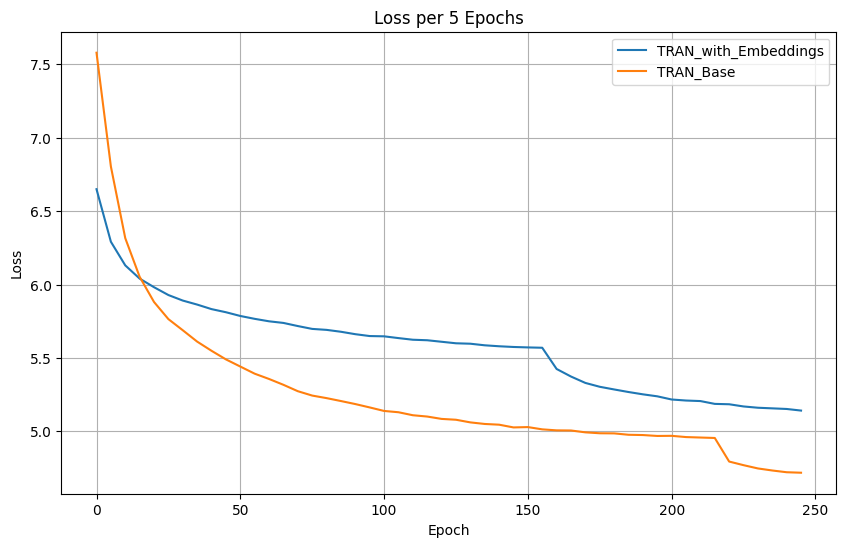

In [ ]:

import matplotlib.pyplot as plt

def plot_losses(TRAN_with_Embeddings, TRAN_Base, BERT_Base, BERT_with_Embeddings):
    # Sample every 5 epochs for each loss list
    epochs_TRAN_with_Embeddings = list(range(0, len(TRAN_with_Embeddings), 5))
    losses_TRAN_with_Embeddings = [TRAN_with_Embeddings[i] for i in epochs_TRAN_with_Embeddings]

    epochs_TRAN_Base = list(range(0, len(TRAN_Base), 5))
    losses_TRAN_Base = [TRAN_Base[i] for i in epochs_TRAN_Base]

    epochs_BERT_Base = list(range(0, len(BERT_Base), 5))
    losses_BERT_Base = [BERT_Base[i] for i in epochs_BERT_Base]

    epochs_BERT_with_Embeddings = list(range(0, len(BERT_with_Embeddings), 5))
    losses_BERT_with_Embeddings = [BERT_with_Embeddings[i] for i in epochs_BERT_with_Embeddings]

    # Plotting the losses
    plt.figure(figsize=(10, 6))

    plt.plot(epochs_TRAN_with_Embeddings, losses_TRAN_with_Embeddings, label='TRAN_with_Embeddings')
    plt.plot(epochs_TRAN_Base, losses_TRAN_Base, label='TRAN_Base')
    #plt.plot(epochs_BERT_Base, losses_BERT_Base, label='BERT_Base')
    #plt.plot(epochs_BERT_with_Embeddings, losses_BERT_with_Embeddings, label='BERT_with_Embeddings')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per 5 Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(TRAN_with_Embeddings, TRAN_Base, BERT_Base, BERT_with_Embeddings)